In [1]:
# Import necessary dependencies
import sys
import os
import zipfile

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
current_dir = os.getcwd()

# Project directory
project_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
sys.path.append(project_dir)

# Python file for custom functions
from src.utils import *

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Directory to your zipfile
ZIPFILE_PATH = os.path.join(project_dir, 'datasets', 'ICPSR_38925-V1.zip')

# Directories to the parquet files
DS0001 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/batch_header_extract_ds0001.parquet')
DS0002 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/admin_extract_ds0002.parquet')
DS0003 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/incident_extract_ds0003.parquet')
DS0004 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/victim_extract_ds0004.parquet')
DS0005 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/arrestee_extract_ds0005.parquet')
DS0006 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/offender_extract_ds0006.parquet')

# Directory to your codebook
CODEBOOK_PATH = os.path.join(project_dir, '38925-Documentation-PI_Codebook.xlsx')  # extracted
# CODEBOOK_PATH = 'ICPSR_38925-V1/ICPSR_38925/38925-Documentation-PI_Codebook.xlsx'  # in the zipfile

In [3]:
# Access to zip file
czip = zipfile.ZipFile(ZIPFILE_PATH)
czip.namelist()

['ICPSR_38925-V1/',
 'ICPSR_38925-V1/ICPSR_38925/',
 'ICPSR_38925-V1/ICPSR_38925/38925-Documentation-PI_Codebook.xlsx',
 'ICPSR_38925-V1/ICPSR_38925/DS0001/',
 'ICPSR_38925-V1/ICPSR_38925/DS0001/38925-0001-Data.tsv',
 'ICPSR_38925-V1/ICPSR_38925/DS0001/38925-0001-Codebook-ICPSR.pdf',
 'ICPSR_38925-V1/ICPSR_38925/DS0002/',
 'ICPSR_38925-V1/ICPSR_38925/DS0002/38925-0002-Codebook-ICPSR.pdf',
 'ICPSR_38925-V1/ICPSR_38925/DS0002/38925-0002-Data.tsv',
 'ICPSR_38925-V1/ICPSR_38925/DS0003/',
 'ICPSR_38925-V1/ICPSR_38925/DS0003/38925-0003-Data.tsv',
 'ICPSR_38925-V1/ICPSR_38925/DS0003/38925-0003-Documentation-readme_gzip.txt',
 'ICPSR_38925-V1/ICPSR_38925/DS0003/38925-0003-Codebook-ICPSR.pdf',
 'ICPSR_38925-V1/ICPSR_38925/38925-related_literature.txt',
 'ICPSR_38925-V1/ICPSR_38925/38925-manifest.txt',
 'ICPSR_38925-V1/ICPSR_38925/38925-descriptioncitation.html',
 'ICPSR_38925-V1/ICPSR_38925/TermsOfUse.html',
 'ICPSR_38925-V1/ICPSR_38925/DS0004/',
 'ICPSR_38925-V1/ICPSR_38925/DS0004/38925-0004-D

In [4]:
# Look up column names and data types
incident_schema = pl.read_parquet_schema(DS0003)
incident_schema

{'V40261': String,
 'ALLOFNS-ALL OFFENSE CODES FOR THE INCIDENT': String,
 'BH005-DATE ORI WAS ADDED': Datetime(time_unit='us', time_zone=None),
 'BH006-DATE ORI WENT NIBRS': Datetime(time_unit='us', time_zone=None),
 'BH007-CITY NAME': String,
 'BH008-STATE ABBREVIATION': String,
 'BH009-POPULATION GROUP': String,
 'BH010-COUNTRY DIVISION': String,
 'BH011-COUNTRY REGION': String,
 'BH012-AGENCY INDICATOR': String,
 'BH013-CORE CITY': String,
 'BH014-COVERED BY ORI': String,
 'BH015-FBI FIELD OFFICE': Int32,
 'BH016-JUDICIAL DISTRICT': String,
 'BH017-AGENCY NIBRS FLAG': String,
 'BH018-AGENCY INACTIVE DATE': Datetime(time_unit='us', time_zone=None),
 'BH019-CURRENT POPULATION 1': Int32,
 'BH020-UCR COUNTY CODE 1': Int32,
 'BH021-MSA CODE 1': Int32,
 'BH022-LAST POPULATION 1': Int32,
 'BH023-CURRENT POPULATION 2': Int32,
 'BH024-UCR COUNTY CODE 2': Int32,
 'BH025-MSA CODE 2': Int32,
 'BH026-LAST POPULATION 2': Int32,
 'BH027-CURRENT POPULATION 3': Int32,
 'BH028-UCR COUNTY CODE 3': In

In [5]:
# Columns with important data
important_data = [
    'STATE-NUMERIC STATE CODE', 'INCNUM-INCIDENT NUMBER', 'INCDATE-INCIDENT DATE',
    'BH007-CITY NAME', 'BH008-STATE ABBREVIATION', 'V1008-TOTAL OFFENSE SEGMENTS',
    'V1009-TOTAL VICTIM SEGMENTS', 'V1010-TOTAL OFFENDER SEGMENTS', 'V1011-TOTAL ARRESTEE SEGMENTS',
    'V20061-UCR OFFENSE CODE - 1', 'V20111-LOCATION TYPE - 1', 'V20141-TYPE CRIMINAL ACTIVITY/GANG INFO 1 - 1',
    'V20171-WEAPON / FORCE 1 - 1', 'V20201-BIAS MOTIVATION 1 - 1', 'V30121-SUSPECTED DRUG TYPE 1 - 1',
    'V40171-TYPE OF VICTIM-1', 'V40181-AGE OF VICTIM-1', 'V40191-SEX OF VICTIM-1',
    'V40201-RACE OF VICTIM-1', 'V40211-ETHNICITY OF VICTIM-1', 'V40221-RESIDENT STATUS OF VICTIM-1',
    'V40321-RELATIONSHIP VIC TO OFF 1-1', 'V50071-AGE OF OFFENDER - 1', 'V50081-SEX OF OFFENDER - 1',
    'V50091-RACE OF OFFENDER - 1', 'V50111-ETHNICITY OF OFFENDER - 1', 'V60081-ARREST DATE - 1',
    'V60121-ARRESTEE ARMED WITH 1 - 1', 'V60141-AGE OF ARRESTEE - 1', 'V60151-SEX OF ARRESTEE - 1',
    'V60161-RACE OF ARRESTEE - 1', 'V60171-ETHNICITY OF ARRESTEE - 1', 'V60181-RESIDENT STATUS OF ARRESTEE - 1',
    'V60191-DISPOSITION OF ARRESTEE UNDER 18 - 1'
]

In [6]:
# Filter incidents in Boston, MA
boston_incident_nibrs = pl.scan_parquet(
    DS0003,
).select(
    important_data
).filter(
    pl.col('BH008-STATE ABBREVIATION').is_in(['MA']),
    pl.col('BH007-CITY NAME').str.to_lowercase().str.contains('boston')
).collect()
boston_incident_nibrs

STATE-NUMERIC STATE CODE,INCNUM-INCIDENT NUMBER,INCDATE-INCIDENT DATE,BH007-CITY NAME,BH008-STATE ABBREVIATION,V1008-TOTAL OFFENSE SEGMENTS,V1009-TOTAL VICTIM SEGMENTS,V1010-TOTAL OFFENDER SEGMENTS,V1011-TOTAL ARRESTEE SEGMENTS,V20061-UCR OFFENSE CODE - 1,V20111-LOCATION TYPE - 1,V20141-TYPE CRIMINAL ACTIVITY/GANG INFO 1 - 1,V20171-WEAPON / FORCE 1 - 1,V20201-BIAS MOTIVATION 1 - 1,V30121-SUSPECTED DRUG TYPE 1 - 1,V40171-TYPE OF VICTIM-1,V40181-AGE OF VICTIM-1,V40191-SEX OF VICTIM-1,V40201-RACE OF VICTIM-1,V40211-ETHNICITY OF VICTIM-1,V40221-RESIDENT STATUS OF VICTIM-1,V40321-RELATIONSHIP VIC TO OFF 1-1,V50071-AGE OF OFFENDER - 1,V50081-SEX OF OFFENDER - 1,V50091-RACE OF OFFENDER - 1,V50111-ETHNICITY OF OFFENDER - 1,V60081-ARREST DATE - 1,V60121-ARRESTEE ARMED WITH 1 - 1,V60141-AGE OF ARRESTEE - 1,V60151-SEX OF ARRESTEE - 1,V60161-RACE OF ARRESTEE - 1,V60171-ETHNICITY OF ARRESTEE - 1,V60181-RESIDENT STATUS OF ARRESTEE - 1,V60191-DISPOSITION OF ARRESTEE UNDER 18 - 1
str,str,datetime[μs],str,str,i32,i32,i32,i32,i32,i32,str,str,i32,str,str,str,str,str,str,str,str,i32,i32,str,i32,datetime[μs],str,i32,i32,str,str,str,i32
"""MA- Massachusetts""","""2W2JGU72870A""",2022-04-05 00:00:00,"""BOSTON""","""MA""",1,1,1,0,238,52,null,null,88,null,"""Individual""","""-7""","""Male""","""Unknown/Missing/DNR""","""Unknown/Missing/DNR""","""Nonresident""",null,0,null,null,null,null,null,null,null,null,null,null,null
"""MA- Massachusetts""","""2W2JGU728XTA""",2022-08-06 00:00:00,"""BOSTON""","""MA""",1,1,1,0,238,52,null,null,88,null,"""Individual""","""32""","""Male""","""White""","""Unknown/Missing/DNR""","""Unknown/Missing/DNR""","""Victim was Stranger""",42,0,"""1""",null,null,null,null,null,null,null,null,null
"""MA- Massachusetts""","""2W2JGU728YBA""",2022-04-07 00:00:00,"""BOSTON""","""MA""",1,1,2,0,233,52,null,null,88,null,"""Business""",null,null,null,null,null,null,22,1,"""Unknown/Missing/DNR""",null,null,null,null,null,null,null,null,null
"""MA- Massachusetts""","""2W2JGU728YJA""",2022-04-14 00:00:00,"""BOSTON""","""MA""",1,1,1,0,238,52,null,null,88,null,"""Individual""","""22""","""Male""","""Unknown/Missing/DNR""","""Unknown/Missing/DNR""","""Nonresident""",null,0,null,null,null,null,null,null,null,null,null,null,null
"""MA- Massachusetts""","""2W2JGU7297 A""",2022-10-25 00:00:00,"""BOSTON""","""MA""",1,1,1,0,233,52,null,null,88,null,"""Business""",null,null,null,null,null,null,20,1,"""1""",null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""MA- Massachusetts""","""VX2TVGRVEVV-""",2022-11-14 00:00:00,"""SOUTH BOSTON""","""MA""",1,1,1,1,351,13,"""Distributing/Selling""",null,88,"""1""","""Society/Public""",null,null,null,null,null,null,43,1,"""2""",0,2022-11-14 00:00:00,"""Unarmed""",43,1,"""2""","""0""","""1""",null
"""MA- Massachusetts""","""VX2TVGRVQH6C""",2022-12-18 00:00:00,"""SOUTH BOSTON""","""MA""",1,1,1,1,351,13,"""Possessing/Concealing""",null,88,"""2""","""Society/Public""",null,null,null,null,null,null,40,1,"""Unknown/Missing/DNR""",1,2022-12-18 00:00:00,"""Unarmed""",40,1,"""Unknown/Missing/DNR""","""1""","""0""",null
"""MA- Massachusetts""","""VX2TVGRVQLF0""",2022-11-27 00:00:00,"""SOUTH BOSTON""","""MA""",1,1,1,1,520,13,"""Possessing/Concealing""","""300""",88,null,"""Society/Public""",null,null,null,null,null,null,40,1,"""1""",0,2022-11-27 00:00:00,"""Club/Blackjack/Brass Knuckles""",40,1,"""1""","""0""","""1""",null


In [7]:
# Double-check all the city names
boston_incident_nibrs['BH007-CITY NAME'].unique()

BH007-CITY NAME
str
"""BOSTON"""
"""SOUTH BOSTON"""
"""Boston"""


In [8]:
# Count null values for each column in boston_incident_nibrs
boston_incident_nibrs.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608 entries, 0 to 1607
Data columns (total 34 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   STATE-NUMERIC STATE CODE                       1608 non-null   object        
 1   INCNUM-INCIDENT NUMBER                         1608 non-null   object        
 2   INCDATE-INCIDENT DATE                          1608 non-null   datetime64[us]
 3   BH007-CITY NAME                                1608 non-null   object        
 4   BH008-STATE ABBREVIATION                       1608 non-null   object        
 5   V1008-TOTAL OFFENSE SEGMENTS                   1608 non-null   int32         
 6   V1009-TOTAL VICTIM SEGMENTS                    1608 non-null   int32         
 7   V1010-TOTAL OFFENDER SEGMENTS                  1608 non-null   int32         
 8   V1011-TOTAL ARRESTEE SEGMENTS                  1608 non-nu

In [9]:
# Data from Boston Police Incident
boston_incident = pd.read_csv(os.path.join(project_dir, 'datasets', 'Boston_arrests.csv'))
boston_incident = boston_incident[boston_incident['Year'] == 2022]  # get the same year as NIBRS 2022
# boston_incident = boston_incident[boston_incident['Month'] > 5]  # avoid report inconsistencies in Boston PD's data
boston_incident

,OBJECTID,Incident Number,Crime,Offense Code,Offense Description,Block Address,City,Zip Code,BPD District,Premise Description,...,Crime Category,Report Date,From Date,To Date,Hour of Day,Day of Week,Year,Quarter,Month,Neighborhood
0,36020,222041820,Other Larceny,619,LARCENY ALL OTHERS,200 BLOCK CAMBRIDGE ST,BRIGHTON,02134,D14,SERVICE/ GAS STATION,...,Property,6/8/2022 6:47:21 PM,6/4/2022 6:38:00 PM,6/8/2022 6:38:00 PM,13.0,7.0,2022.0,2.0,6.0,Allston
1,36021,222041855,Investigate Property,3114,INVESTIGATE PROPERTY,100 BLOCK W BROADWAY,SOUTH BOSTON,02127,C6,HIGHWAY/ ROAD/ ALLEY/ STREET/ SIDEWALK,...,NaN,6/8/2022 8:53:42 PM,6/8/2022 8:45:00 PM,6/8/2022 8:45:00 PM,15.0,4.0,2022.0,2.0,6.0,South Boston
2,36035,222041930,Towed,3410,TOWED MOTOR VEHICLE,0 BLOCK CAUSEWAY ST,BOSTON,02114,A1,HIGHWAY/ ROAD/ ALLEY/ STREET/ SIDEWALK,...,NaN,6/9/2022 12:06:13 AM,6/8/2022 11:26:00 PM,NaN,18.0,4.0,2022.0,2.0,6.0,West End
3,36036,222042063,Violations,2905,VAL - VIOLATION OF AUTO LAW,0 BLOCK BEACH ST,BOSTON,02111,A1,HIGHWAY/ ROAD/ ALLEY/ STREET/ SIDEWALK,...,NaN,6/9/2022 2:07:28 PM,6/3/2022 6:37:00 PM,NaN,13.0,6.0,2022.0,2.0,6.0,Chinatown
4,36051,222034715,Medical Assistance,1831,SICK ASSIST,100 BLOCK PERKINS ST,JAMAICA PLAIN,02130,E13,RESIDENCE/ HOME,...,NaN,5/16/2022 1:58:01 AM,5/16/2022 1:08:00 AM,NaN,20.0,1.0,2022.0,2.0,5.0,Jamaica Plain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212567,1412431,242038133,FRAUD,1102,FRAUD - FALSE PRETENSE / SCHEME,0 BLOCK WINTHROP ST,ROXBURY,02119,B2,HIGHWAY/ ROAD/ ALLEY/ STREET/ SIDEWALK,...,NaN,5/11/2024 3:32:20 PM,2/2/2022 5:00:00 AM,2/2/2022 5:00:00 AM,0.0,4.0,2022.0,1.0,2.0,Roxbury
213174,1413038,242038192,SIMPLE ASSAULT,801,ASSAULT - SIMPLE,NaN,NaN,NaN,E13,NaN,...,NaN,5/11/2024 7:26:23 PM,11/2/2022 12:00:00 AM,5/11/2024 7:08:00 PM,20.0,3.0,2022.0,4.0,11.0,Jamaica Plain
213230,1413094,242038829,FRAUD,1102,FRAUD - FALSE PRETENSE / SCHEME,WILDWOOD ST & MORTON ST,BOSTON,02124,B3,HIGHWAY/ ROAD/ ALLEY/ STREET/ SIDEWALK,...,NaN,5/13/2024 10:28:24 PM,7/19/2022 4:00:00 AM,5/13/2024 4:00:00 AM,0.0,3.0,2022.0,3.0,7.0,Dorchester
213445,1413309,242038650,FRAUD,1107,FRAUD - IMPERSONATION,100 BLOCK GLADSTONE ST,EAST BOSTON,02128,A7,RESIDENCE/ HOME,...,NaN,5/13/2024 2:08:02 PM,3/1/2022 5:01:00 AM,5/13/2024 1:45:00 PM,0.0,3.0,2022.0,1.0,3.0,East Boston


In [10]:
# Look up dtype and non-null count
boston_incident.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67889 entries, 0 to 213621
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OBJECTID             67889 non-null  int64  
 1   Incident Number      67889 non-null  object 
 2   Crime                67889 non-null  object 
 3   Offense Code         67889 non-null  object 
 4   Offense Description  67889 non-null  object 
 5   Block Address        57330 non-null  object 
 6   City                 57337 non-null  object 
 7   Zip Code             57336 non-null  object 
 8   BPD District         67503 non-null  object 
 9   Premise Description  57337 non-null  object 
 10  Weapon Description   4357 non-null   object 
 11  Crime Part           67868 non-null  object 
 12  Crime Category       10448 non-null  object 
 13  Report Date          67889 non-null  object 
 14  From Date            67689 non-null  object 
 15  To Date              23482 non-null  obj

In [11]:
# Count unique offense codes (not UCR)
boston_incident['Offense Code'].value_counts()

Offense Code
3115       5895
3301       5475
1831       4092
801        4040
3831       3064
           ... 
2628          2
1731          1
268/1/A       1
3123          1
1603          1
Name: count, Length: 145, dtype: int64

In [12]:
# Convert the column to datetime
boston_incident['From Date'] = pd.to_datetime(boston_incident['From Date'])

# Format the datetime as 'YYYY-MM-DD HH:MM:SS'
boston_incident['From Date'] = boston_incident['From Date'].dt.strftime('%Y-%m-%d %H:%M:%S')
boston_incident['From Date']

0         2022-06-04 18:38:00
1         2022-06-08 20:45:00
2         2022-06-08 23:26:00
3         2022-06-03 18:37:00
4         2022-05-16 01:08:00
                 ...         
212567    2022-02-02 05:00:00
213174    2022-11-02 00:00:00
213230    2022-07-19 04:00:00
213445    2022-03-01 05:01:00
213621    2022-08-20 16:00:00
Name: From Date, Length: 67889, dtype: object

In [13]:
# Convert the polars DataFrame to pandas
boston_incident_nibrs = boston_incident_nibrs.to_pandas()

In [14]:
# Convert the datetime columns to datetime dtype
boston_incident_nibrs['INCDATE-INCIDENT DATE'] = pd.to_datetime(boston_incident_nibrs['INCDATE-INCIDENT DATE'])
# boston_incident_nibrs = boston_incident_nibrs[boston_incident_nibrs['INCDATE-INCIDENT DATE'].dt.month > 5]
boston_incident['From Date'] = pd.to_datetime(boston_incident['From Date'])

# Group by date and count occurrences
nibrs_count = boston_incident_nibrs.groupby(
    boston_incident_nibrs['INCDATE-INCIDENT DATE'].dt.date
).size().reset_index(name='Count')
bpd_count = boston_incident.groupby(
    boston_incident['From Date'].dt.date
).size().reset_index(name='Count')

# Rename the datetime column to 'Time'
nibrs_count.rename(columns={'INCDATE-INCIDENT DATE': 'Time'}, inplace=True)
bpd_count.rename(columns={'From Date': 'Time'}, inplace=True)

In [15]:
nibrs_count

,Time,Count
0,2022-01-01,1
1,2022-01-02,1
2,2022-01-03,4
3,2022-01-04,3
4,2022-01-05,1
...,...,...
352,2022-12-27,4
353,2022-12-28,3
354,2022-12-29,2
355,2022-12-30,1


In [16]:
bpd_count

,Time,Count
0,2022-01-01,39
1,2022-01-02,3
2,2022-01-03,1
3,2022-01-04,1
4,2022-01-06,4
...,...,...
352,2022-12-28,274
353,2022-12-29,236
354,2022-12-30,280
355,2022-12-31,292


In [17]:
# Compare NIBRS's data volume to the the city's
temp = bpd_count.merge(
    nibrs_count, 
    on='Time', 
    how='inner',
)
temp['Ratio'] = temp['Count_y'] / temp['Count_x']
discrepancy = temp['Ratio'].mean()
discrepancy

0.562170329477278

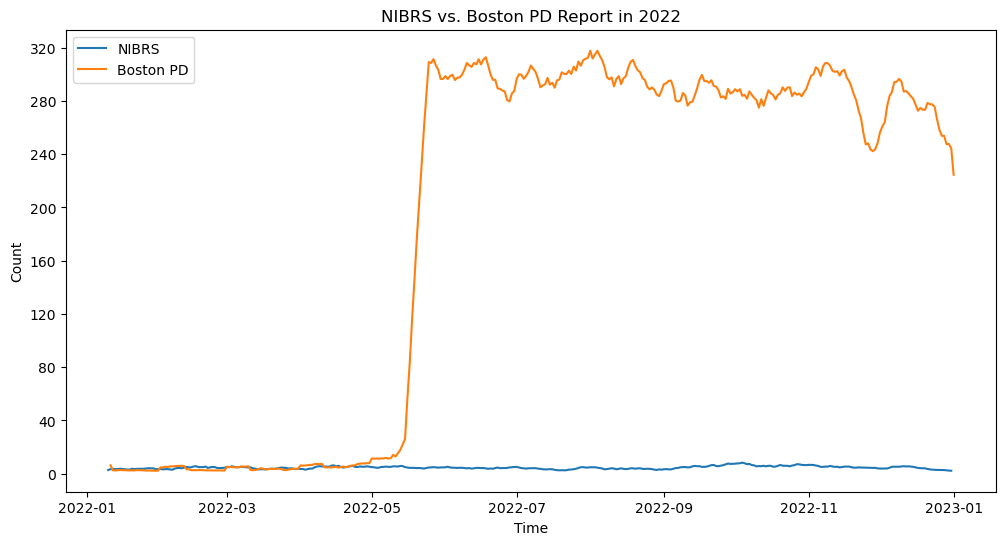

In [18]:
from matplotlib.ticker import MaxNLocator

# Plot report frequencies of NIBRS vs. Boston PD in 2022 (rolling average)
plt.figure(figsize=(12, 6))
plt.plot(nibrs_count['Time'], nibrs_count['Count'].rolling(10).mean(), label='NIBRS')
plt.plot(bpd_count['Time'], bpd_count['Count'].rolling(10).mean(), label='Boston PD')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('NIBRS vs. Boston PD Report in 2022')
plt.legend()
plt.savefig('boston_volume.png', bbox_inches='tight')
plt.show()

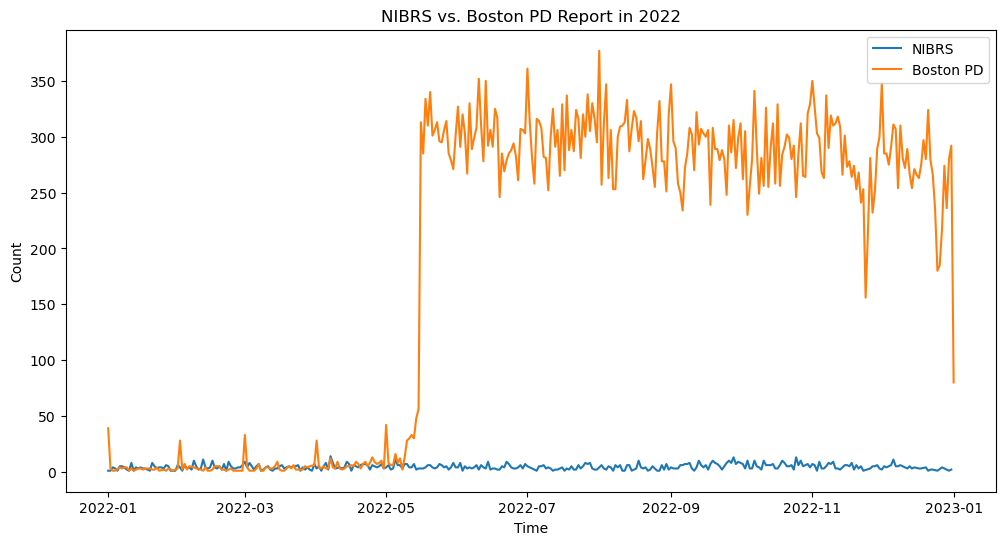

In [19]:
# Plot report frequencies of NIBRS vs. Boston PD in 2022
plt.figure(figsize=(12, 6))
plt.plot(nibrs_count['Time'], nibrs_count['Count'], label='NIBRS')
plt.plot(bpd_count['Time'], bpd_count['Count'], label='Boston PD')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('NIBRS vs. Boston PD Report in 2022')
plt.legend()
plt.show()

In [20]:
# Get correlations
combined_counts = nibrs_count.rename(
    columns={'Count': 'NIBRS'}
).merge(
    bpd_count.rename(
        columns={'Count': 'Boston'}
    )
).set_index('Time')

combined_counts.corr()

,NIBRS,Boston
NIBRS,1.0000,0.0206
Boston,0.0206,1.0000


In [21]:
# Get a list of unique offenses in Boston
unique_boston_offenses = boston_incident['Offense Description'].dropna().str.lower().str.replace('m/v', 'motor/vehicle').unique().tolist()
unique_boston_offenses

['larceny all others',
 'investigate property',
 'towed motor vehicle',
 'val - violation of auto law',
 'sick assist',
 'assault - simple',
 'fraud - false pretense / scheme',
 'vandalism',
 'motor/vehicle - leaving scene - property damage',
 'sexual assault investigation',
 'investigate person',
 'assault - aggravated',
 'warrant arrest - boston warrant (must be supplemental)',
 'failure to register as a sex offender',
 'sick assist - drug related illness',
 'larceny theft from building',
 'threats to do bodily harm',
 'verbal dispute',
 'sex offense - rape - forcible',
 'weapon violation - carry/ possessing/ sale/ trafficking/ other',
 'sick/injured/medical - person',
 'motor/vehicle accident - personal injury',
 'larceny theft of mv parts & accessories',
 'larceny theft from mv - non-accessory',
 'motor/vehicle accident - other',
 'motor/vehicle - leaving scene - personal injury',
 'auto theft',
 'property - found',
 'burglary - residential',
 'property - lost/ missing',
 'search w

In [22]:
# Count the total number of unique offenses in Boston
len(unique_boston_offenses)

147

In [23]:
# Search the UCR offense codes in the NIBRS codebook
codebook = pd.read_excel(CODEBOOK_PATH, sheet_name='Incident Extract').ffill()
codebook = codebook[codebook['Variable Name'] == 'V20061']

# Create the mapping dictionary
mapper = dict(zip(codebook['Value'], codebook['Value Label']))
mapper

{91: 'Murder/Nonnegligent Manslaughter',
 92: 'Negligent Manslaughter',
 93: 'Justifiable Homicide',
 100: 'Kidnaping/Abduction',
 111: 'Rape',
 112: 'Sodomy',
 113: 'Sexual Assault With An Object',
 114: 'Fondling (Indecent Liberties/Child Molesting)',
 120: 'Robbery',
 131: 'Aggravated Assault',
 132: 'Simple Assault',
 133: 'Intimidation',
 200: 'Arson',
 210: 'Extortion/Blackmail',
 220: 'Burglary/Breaking and Entering',
 231: 'Pocket-picking',
 232: 'Purse-snatching',
 233: 'Shoplifting',
 234: 'Theft From Building',
 235: 'Theft From Coin-Operated Machine or Device',
 236: 'Theft From Motor Vehicle',
 237: 'Theft of Motor Vehicle Parts/Accessories',
 238: 'All Other Larceny',
 240: 'Motor Vehicle Theft',
 250: 'Counterfeiting/Forgery',
 261: 'False Pretenses/Swindle/Confidence Game',
 262: 'Credit Card/Automatic Teller Machine Fraud',
 263: 'Impersonation',
 264: 'Welfare Fraud',
 265: 'Wire Fraud',
 266: 'Identity Theft',
 267: 'Hacking/Computer Invasion',
 270: 'Embezzlement',


In [24]:
# Replace the values in 'V20061-UCR OFFENSE CODE - 1' with the UCR descriptions
boston_incident_nibrs['V20061-UCR OFFENSE CODE - 1'] = boston_incident_nibrs['V20061-UCR OFFENSE CODE - 1'].map(mapper)
unique_nibrs_offenses = boston_incident_nibrs['V20061-UCR OFFENSE CODE - 1'].dropna().str.lower().unique().tolist()
unique_nibrs_offenses

['all other larceny',
 'shoplifting',
 'simple assault',
 'destruction/damage/vandalism of property',
 'stolen property offenses',
 'drug/narcotic violations',
 'weapon law violations',
 'motor vehicle theft',
 'burglary/breaking and entering',
 'aggravated assault',
 'animal cruelty',
 'theft from building',
 'fondling (indecent liberties/child molesting)',
 'intimidation',
 'credit card/automatic teller machine fraud',
 'false pretenses/swindle/confidence game',
 'wire fraud',
 'theft of motor vehicle parts/accessories',
 'extortion/blackmail',
 'identity theft',
 'robbery',
 'rape',
 'pocket-picking',
 'theft from motor vehicle',
 'counterfeiting/forgery',
 'kidnaping/abduction',
 'impersonation',
 'statutory rape',
 'theft from coin-operated machine or device',
 'hacking/computer invasion',
 'bribery',
 'drug equipment violations',
 'human trafficking- involuntary servitude',
 'purse-snatching',
 'negligent manslaughter',
 'pornography/obscene material']

In [25]:
from sentence_transformers import SentenceTransformer

# Use a transformer model to embed texts as matrices
st_model = SentenceTransformer(model_name_or_path='sentence-transformers/all-MiniLM-L6-v2')

boston_embeddings = st_model.encode(unique_boston_offenses)
nibrs_embeddings = st_model.encode(unique_nibrs_offenses)

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

# Use cosine similarity to compare offense descriptions
embedding_array = cosine_similarity(
    nibrs_embeddings,
    boston_embeddings,
)

sim_df = pl.DataFrame(
    embedding_array,
    schema=unique_boston_offenses,
).with_columns(
    pl.Series(name='NIBRS Descriptions', values=unique_nibrs_offenses)
).melt(
    id_vars='NIBRS Descriptions',
    variable_name='Boston Descriptions',
    value_name='Cosine Similarity'
).sort(
    'Cosine Similarity',
    descending=True,
)

sim_df

NIBRS Descriptions,Boston Descriptions,Cosine Similarity
str,str,f32
"""robbery""","""robbery""",1.0
"""human trafficking- involuntary…","""human trafficking - involuntar…",1.0
"""counterfeiting/forgery""","""forgery / counterfeiting""",0.985674
"""extortion/blackmail""","""extortion or blackmail""",0.977391
"""aggravated assault""","""assault - aggravated""",0.966623
…,…,…
"""credit card/automatic teller m…","""indecent exposure/ lewd and la…",-0.081566
"""human trafficking- involuntary…","""motor/vehicle accident - prope…",-0.082299
"""wire fraud""","""val - operating after rev/susp…",-0.084115


In [27]:
# Create a dictionary with Boston descriptions as keys and NIBRS descriptions as values
# Group by 'Boston Descriptions' and take the first row for each group (highest similarity)
boston_nibrs_dict = sim_df.group_by(
    'Boston Descriptions',
    maintain_order=True,
).agg(
    pl.col('NIBRS Descriptions').first()
).to_pandas().set_index(
    'Boston Descriptions'
).to_dict()['NIBRS Descriptions']

# Display the resulting dictionary
boston_nibrs_dict

{'robbery': 'robbery',
 'human trafficking - involuntary servitude': 'human trafficking- involuntary servitude',
 'forgery / counterfeiting': 'counterfeiting/forgery',
 'extortion or blackmail': 'extortion/blackmail',
 'assault - aggravated': 'aggravated assault',
 'larceny all others': 'all other larceny',
 'assault - simple': 'simple assault',
 'fraud - wire': 'wire fraud',
 'obscene materials - pornography': 'pornography/obscene material',
 'murder, non-negligent manslaughter': 'negligent manslaughter',
 'kidnapping/custodial kidnapping/ abduction': 'kidnaping/abduction',
 'murder, non-negligient manslaughter': 'negligent manslaughter',
 'larceny theft from building': 'theft from building',
 'sex offense - statutory rape': 'statutory rape',
 'fondling - indecent assault': 'fondling (indecent liberties/child molesting)',
 'larceny shoplifting': 'shoplifting',
 'fraud - impersonation': 'impersonation',
 'auto theft': 'motor vehicle theft',
 'larceny theft from coin-op machine': 'theft

In [28]:
# Output the dictionary to a JSON file
with open('boston_NIBRS_similarity.json', 'w') as fout:
    json.dump(boston_nibrs_dict, fout, indent=4)

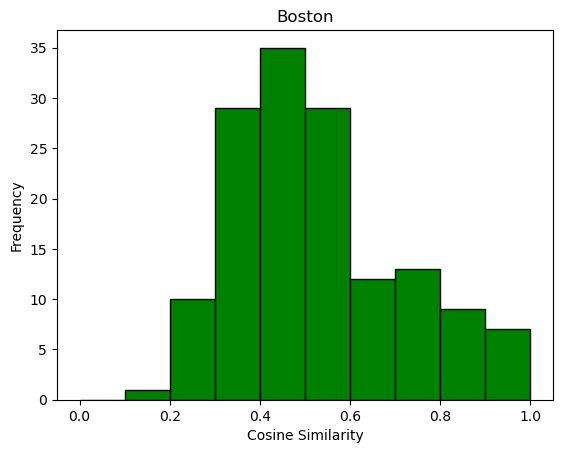

In [29]:
# Visualize the distribution of offense descriptions' cosine similarity
hist_data = sim_df.group_by(
    'Boston Descriptions',
    maintain_order=True,
).agg(
    pl.col('NIBRS Descriptions').first(),
    pl.col('Cosine Similarity').first()
).to_pandas()['Cosine Similarity']

# Plotting the histogram
hist_data.plot(
    kind='hist',
    bins=np.arange(0, 1.01, 0.1),
    color='green',
    edgecolor='k'
)

plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Boston')
plt.savefig('boston_cos_sim.png', bbox_inches='tight')
plt.show()